<a href="https://colab.research.google.com/github/DhekerKacem/FuturVisionTransport/blob/main/modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install imgaug

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Chargement des bibliothèques

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
import random
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K

### Analyse exploratoire

Original Mask 1 Unique Labels: [  0  16  26  45  70  76  84  90 117 119 153 194 210]
Converted Mask 1 Unique Labels: [0 2 7]


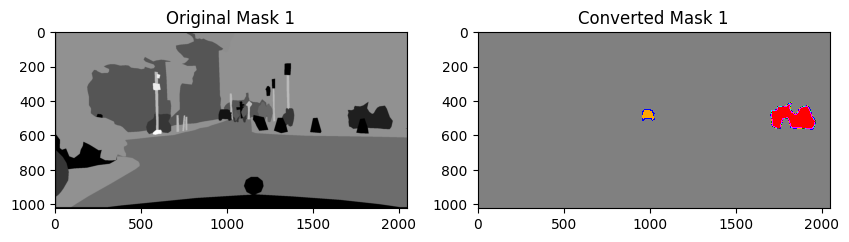

Original Mask 2 Unique Labels: [  0  16  45  58  70  76  84  90 108 117 119 153 177 194]
Converted Mask 2 Unique Labels: [0 2]


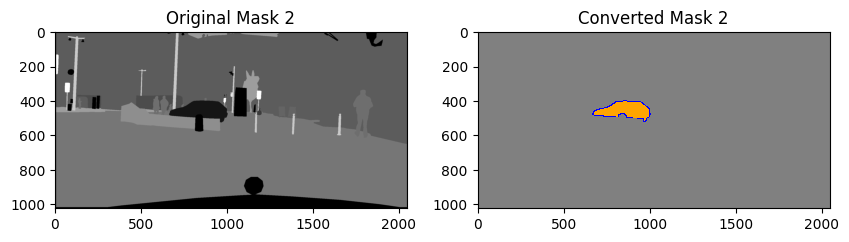

Original Mask 3 Unique Labels: [  0  16  26  45  58  70  76  84  90 117 119 153 192 194 210]
Converted Mask 3 Unique Labels: [0 2 7]


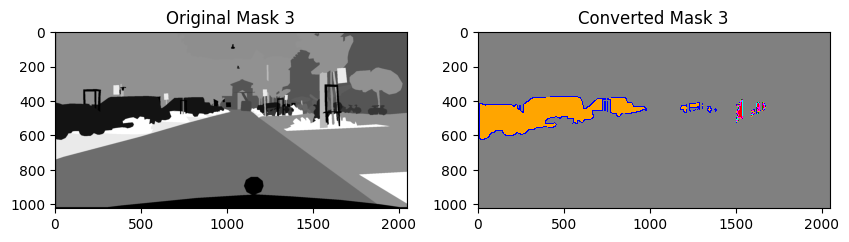

Original Mask 4 Unique Labels: [  0  16  45  70  76  84  90 117 119 153 177 192 194 210]
Converted Mask 4 Unique Labels: [0 2]


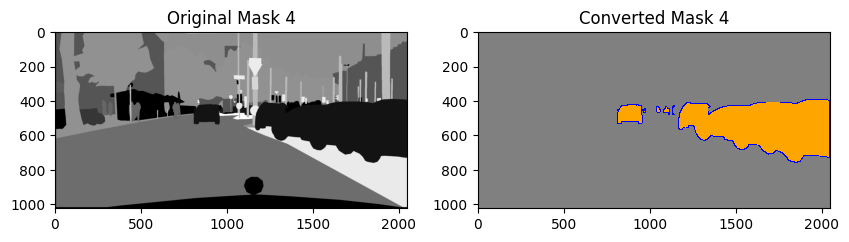

Original Mask 5 Unique Labels: [  0  16  70  76  84  90 117 119 153]
Converted Mask 5 Unique Labels: [0 2]


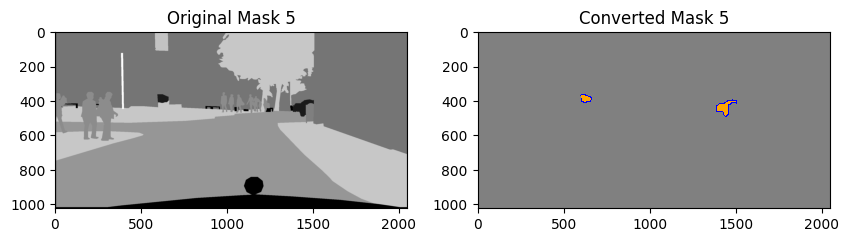

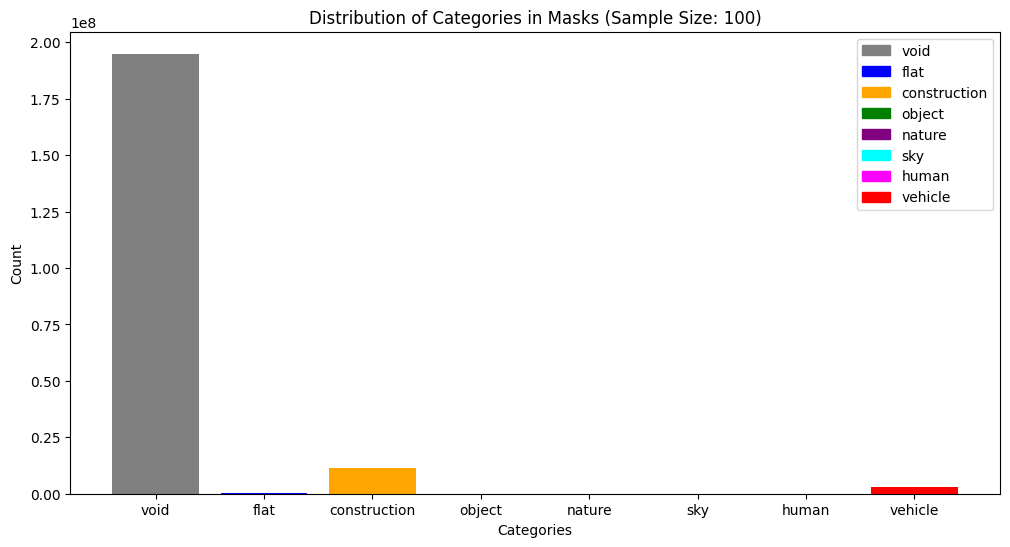

In [7]:
# Définir les catégories et les couleurs
CATS = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

category_colors = {
    'void': 'gray',
    'flat': 'blue',
    'construction': 'orange',
    'object': 'green',
    'nature': 'purple',
    'sky': 'cyan',
    'human': 'magenta',
    'vehicle': 'red'
}

# Fonction pour convertir les masques
def _convert_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
    for i in range(-1, 34):
        if i in CATS['void']:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
        elif i in CATS['flat']:
            mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
        elif i in CATS['construction']:
            mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
        elif i in CATS['object']:
            mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
        elif i in CATS['nature']:
            mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
        elif i in CATS['sky']:
            mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
        elif i in CATS['human']:
            mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
        elif i in CATS['vehicle']:
            mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
    return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour charger les masques et extraire les labels par catégorie
def get_category_distribution(mask_paths):
    category_counts = {cat: 0 for cat in CATS.keys()}
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)
        unique, counts = np.unique(converted_mask, return_counts=True)
        for label, count in zip(unique, counts):
            category = list(CATS.keys())[label]
            category_counts[category] += count
    return category_counts

# Fonction pour obtenir les chemins des masques
def get_mask_paths(mask_base_dir, sample_size=None):
    mask_paths = []
    for root, dirs, files in os.walk(mask_base_dir):
        for file in files:
            if file.endswith('_gtFine_color.png'):
                mask_paths.append(os.path.join(root, file))
    if sample_size:
        mask_paths = random.sample(mask_paths, sample_size)
    return mask_paths

# Fonction pour visualiser quelques masques
def visualize_masks(mask_paths, num_samples=5):
    # Définir la palette de couleurs
    colors = [category_colors[cat] for cat in CATS.keys()]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(range(len(CATS) + 1), cmap.N)

    for i, mask_path in enumerate(random.sample(mask_paths, num_samples)):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)

        # Étape de débogage : Afficher les valeurs uniques dans les masques
        print(f"Original Mask {i+1} Unique Labels: {np.unique(mask)}")
        print(f"Converted Mask {i+1} Unique Labels: {np.unique(converted_mask)}")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Original Mask {i+1}')
        plt.imshow(mask, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Converted Mask {i+1}')
        plt.imshow(converted_mask, cmap=cmap, norm=norm)

        plt.show()

# Chemin vers le répertoire des masques
mask_base_dir = '/content/drive/My Drive//data/gtFine/train'

# Définir la taille de l'échantillon
sample_size = 100  # Vous pouvez ajuster cette valeur selon vos besoins

# Obtenir les chemins des masques avec un échantillon
mask_paths = get_mask_paths(mask_base_dir, sample_size)

# Visualiser quelques masques pour vérifier
visualize_masks(mask_paths)

# Obtenir la distribution des catégories
category_distribution = get_category_distribution(mask_paths)

# Convertir la distribution en DataFrame pour une meilleure visualisation
df = pd.DataFrame(list(category_distribution.items()), columns=['Category', 'Count'])

# Mapper les couleurs pour chaque catégorie
df['Color'] = df['Category'].map(category_colors)

# Afficher la distribution sous forme de bar plot avec des couleurs
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Count'], color=df['Color'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories in Masks (Sample Size: {sample_size})')

# Ajouter une légende
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in category_colors]
labels = [cat for cat in category_colors]
plt.legend(handles, labels)

plt.show()


Original Mask 1 Unique Labels: [ 1  2  3  7  8  9 11 12 13 17 21 26]
Converted Mask 1 Unique Labels: [0 1 2 3 4 7]


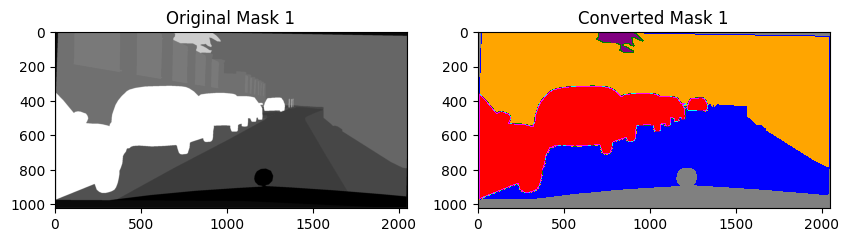

Original Mask 2 Unique Labels: [ 1  3  4  7  8  9 11 12 17 19 20 21 22 23 26 27]
Converted Mask 2 Unique Labels: [0 1 2 3 4 5 7]


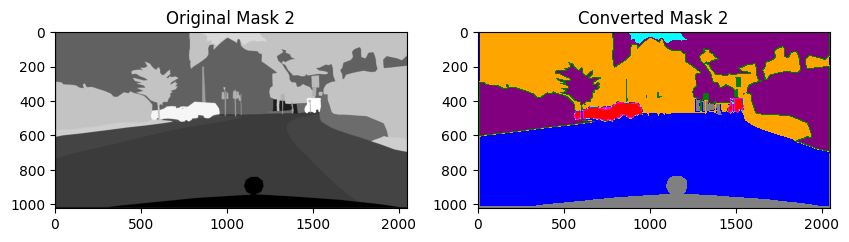

Original Mask 3 Unique Labels: [ 1  2  3  4  5  7  8 10 11 17 20 21 23 24 25 26 31 32 33]
Converted Mask 3 Unique Labels: [0 1 2 3 4 5 6 7]


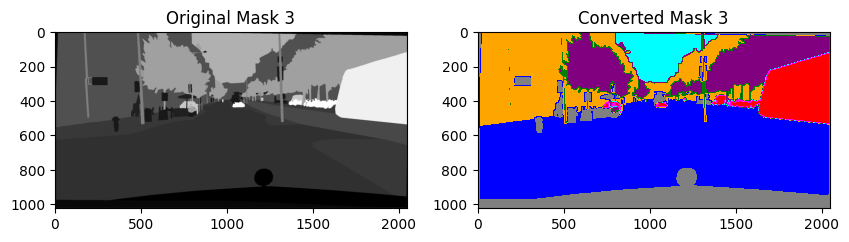

Original Mask 4 Unique Labels: [ 1  3  4  5  7  8 11 12 17 19 20 21 23 24 25 26 33]
Converted Mask 4 Unique Labels: [0 1 2 3 4 5 6 7]


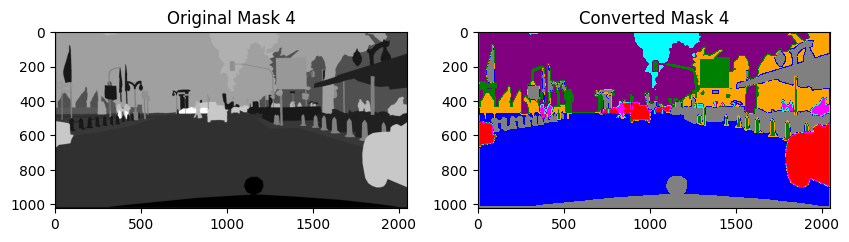

Original Mask 5 Unique Labels: [ 1  2  3  4  5  7  9 11 17 20 21 23 24 25 26]
Converted Mask 5 Unique Labels: [0 1 2 3 4 5 6 7]


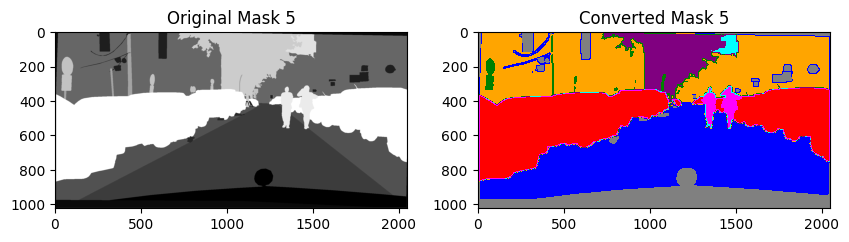

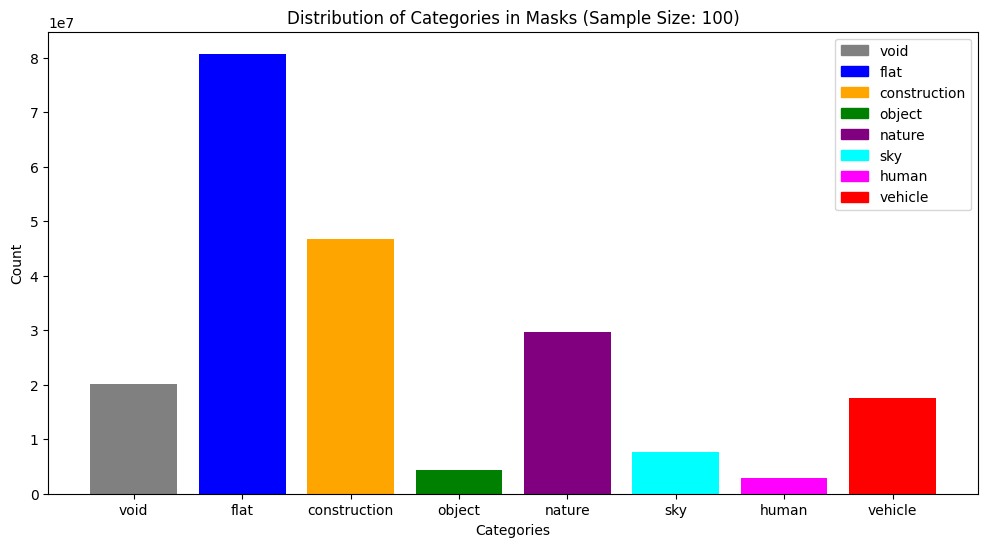

In [8]:
# Définir les catégories et les couleurs
CATS = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

category_colors = {
    'void': 'gray',
    'flat': 'blue',
    'construction': 'orange',
    'object': 'green',
    'nature': 'purple',
    'sky': 'cyan',
    'human': 'magenta',
    'vehicle': 'red'
}

# Fonction pour convertir les masques
def _convert_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
    for i in range(-1, 34):
        if i in CATS['void']:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
        elif i in CATS['flat']:
            mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
        elif i in CATS['construction']:
            mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
        elif i in CATS['object']:
            mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
        elif i in CATS['nature']:
            mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
        elif i in CATS['sky']:
            mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
        elif i in CATS['human']:
            mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
        elif i in CATS['vehicle']:
            mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
    return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour charger les masques et extraire les labels par catégorie
def get_category_distribution(mask_paths):
    category_counts = {cat: 0 for cat in CATS.keys()}
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)
        unique, counts = np.unique(converted_mask, return_counts=True)
        for label, count in zip(unique, counts):
            category = list(CATS.keys())[label]
            category_counts[category] += count
    return category_counts

# Fonction pour obtenir les chemins des masques
def get_mask_paths(mask_base_dir, sample_size=None):
    mask_paths = []
    for root, dirs, files in os.walk(mask_base_dir):
        for file in files:
            if file.endswith('_gtFine_labelIds.png'):
                mask_paths.append(os.path.join(root, file))
    if sample_size:
        mask_paths = random.sample(mask_paths, sample_size)
    return mask_paths

# Fonction pour visualiser quelques masques
def visualize_masks(mask_paths, num_samples=5):
    # Définir la palette de couleurs
    colors = [category_colors[cat] for cat in CATS.keys()]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(range(len(CATS) + 1), cmap.N)

    for i, mask_path in enumerate(random.sample(mask_paths, num_samples)):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)

        # Étape de débogage : Afficher les valeurs uniques dans les masques
        print(f"Original Mask {i+1} Unique Labels: {np.unique(mask)}")
        print(f"Converted Mask {i+1} Unique Labels: {np.unique(converted_mask)}")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Original Mask {i+1}')
        plt.imshow(mask, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Converted Mask {i+1}')
        plt.imshow(converted_mask, cmap=cmap, norm=norm)

        plt.show()

# Chemin vers le répertoire des masques
mask_base_dir = '/content/drive/My Drive//data/gtFine/train'

# Définir la taille de l'échantillon
sample_size = 100  # Vous pouvez ajuster cette valeur selon vos besoins

# Obtenir les chemins des masques avec un échantillon
mask_paths = get_mask_paths(mask_base_dir, sample_size)

# Visualiser quelques masques pour vérifier
visualize_masks(mask_paths)

# Obtenir la distribution des catégories
category_distribution = get_category_distribution(mask_paths)

# Convertir la distribution en DataFrame pour une meilleure visualisation
df = pd.DataFrame(list(category_distribution.items()), columns=['Category', 'Count'])

# Mapper les couleurs pour chaque catégorie
df['Color'] = df['Category'].map(category_colors)

# Afficher la distribution sous forme de bar plot avec des couleurs
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Count'], color=df['Color'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories in Masks (Sample Size: {sample_size})')

# Ajouter une légende
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in category_colors]
labels = [cat for cat in category_colors]
plt.legend(handles, labels)

plt.show()

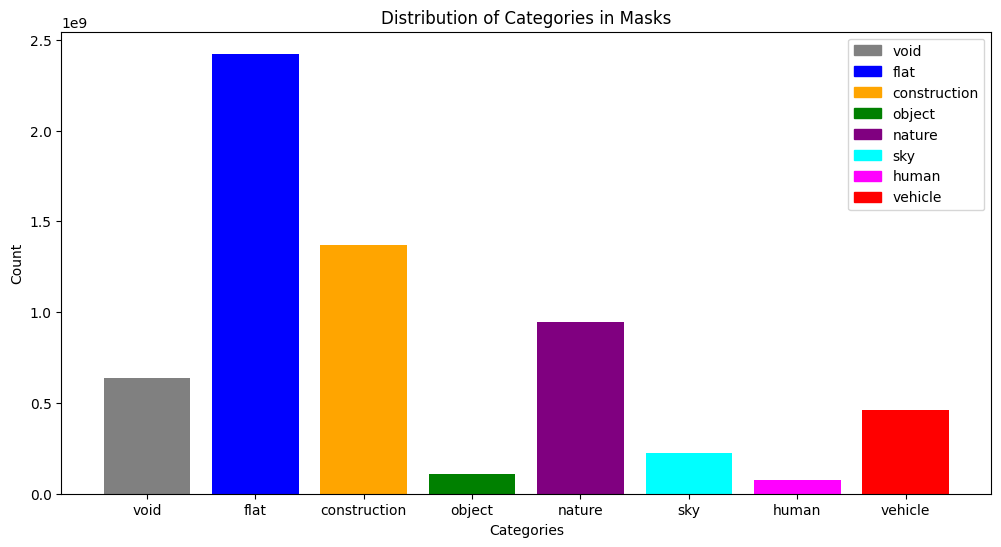

In [26]:
# Définir les catégories et les couleurs
CATS = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

category_colors = {
    'void': 'gray',
    'flat': 'blue',
    'construction': 'orange',
    'object': 'green',
    'nature': 'purple',
    'sky': 'cyan',
    'human': 'magenta',
    'vehicle': 'red'
}

# Fonction pour convertir les masques
def _convert_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
    for i in range(-1, 34):
        if i in CATS['void']:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
        elif i in CATS['flat']:
            mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
        elif i in CATS['construction']:
            mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
        elif i in CATS['object']:
            mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
        elif i in CATS['nature']:
            mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
        elif i in CATS['sky']:
            mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
        elif i in CATS['human']:
            mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
        elif i in CATS['vehicle']:
            mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
    return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour charger les masques et extraire les labels par catégorie
def get_category_distribution(mask_paths):
    category_counts = {cat: 0 for cat in CATS.keys()}
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)
        unique, counts = np.unique(converted_mask, return_counts=True)
        for label, count in zip(unique, counts):
            category = list(CATS.keys())[label]
            category_counts[category] += count
    return category_counts

# Fonction pour obtenir les chemins des masques
def get_mask_paths(mask_base_dir):
    mask_paths = []
    for root, dirs, files in os.walk(mask_base_dir):
        for file in files:
            if file.endswith('_gtFine_labelIds.png'):
                mask_paths.append(os.path.join(root, file))
    return mask_paths

# Chemin vers le répertoire des masques
mask_base_dir = '/content/drive/My Drive//data/gtFine/train'

# Obtenir les chemins des masques
mask_paths = get_mask_paths(mask_base_dir)

# Obtenir la distribution des catégories
category_distribution = get_category_distribution(mask_paths)

# Convertir la distribution en DataFrame pour une meilleure visualisation
df = pd.DataFrame(list(category_distribution.items()), columns=['Category', 'Count'])

# Mapper les couleurs pour chaque catégorie
df['Color'] = df['Category'].map(category_colors)

# Afficher la distribution sous forme de bar plot avec des couleurs
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Count'], color=df['Color'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Categories in Masks')

# Ajouter une légende
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in category_colors]
labels = [cat for cat in category_colors]
plt.legend(handles, labels)

plt.show()

### Définition de la métrique personnalisée

In [9]:
class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', num_classes=8, **kwargs):
        super(CustomMeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count_classes = self.add_weight(name='count_classes', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        if len(y_true.shape) == 4:
            y_true = tf.argmax(y_true, axis=-1)
            y_pred = tf.argmax(y_pred, axis=-1)

        mean_iou = 0.0
        class_count = 0.0

        for i in range(self.num_classes):
            true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
            pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

            intersection = K.sum(true_class * pred_class)
            union = K.sum(true_class) + K.sum(pred_class) - intersection

            iou = intersection / (union + K.epsilon())
            condition = K.equal(union, 0)
            mean_iou = K.switch(condition, mean_iou, mean_iou + iou)
            class_count = K.switch(condition, class_count, class_count + 1)

        self.total_iou.assign_add(mean_iou)
        self.count_classes.assign_add(class_count)

    def result(self):
        return self.total_iou / (self.count_classes + K.epsilon())

    def reset_state(self):
        self.total_iou.assign(0.0)
        self.count_classes.assign(0.0)

#### Générateur de données

#### Générateur avec augmentation

In [10]:
class DataLoadGenerator(Sequence):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, batch_size, augment=False, shuffle=True):
        """
        Générateur de données avec ou sans augmentation des images
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        x,y= self._prepare_data(batch_x,batch_y)
        return x,y

    def _prepare_data(self, image_paths, mask_paths):
        x = []
        y = []
        for idx, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img, mask = self._get_image_and_mask(img_path, mask_path)
            if self.augment:
                img, mask = self._augment_image(img, mask)
            x.append(img)
            y.append(mask)
        x = np.array(x, dtype=np.float32) / 255.0
        y = np.array(y, dtype=np.uint8)
        y = np.expand_dims(y, axis=-1)
        y = to_categorical(y, num_classes=8)
        return x, y

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

    def _augment_image(self, img, mask):
        segmap = SegmentationMapsOnImage(mask, shape=img.shape)

        seq = iaa.Sequential([
            iaa.Affine(rotate=(-10, 10)),
            iaa.GammaContrast((0.5, 2.0)),
            iaa.Fliplr(0.5),
            iaa.CropAndPad(px=(-10, 10)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))
        ])

        ia.seed(2)
        img_aug, segmap_aug = seq(image=img, segmentation_maps=segmap)
        final_img = img_aug
        final_mask = segmap_aug.get_arr()

        return final_img, final_mask

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Obtenir les chemins pour l'entraînement
train_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/train'
train_mask_base_dir = '/content/drive/My Drive//data/gtFine/train'
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_image_base_dir, train_mask_base_dir)

# Obtenir les chemins pour la validation
val_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/val'
val_mask_base_dir = '/content/drive/My Drive//data/gtFine/val'
val_image_paths, val_mask_paths = get_image_and_mask_paths(val_image_base_dir, val_mask_base_dir)

# Obtenir les chemins pour le test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive//data/gtFine/test'
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Création des DataLoaders
train_loader = DataLoadGenerator(train_image_paths, train_mask_paths, crop_x=512, crop_y=512, batch_size=8, augment=True)
val_loader = DataLoadGenerator(val_image_paths, val_mask_paths, crop_x=512, crop_y=512, batch_size=8, augment=False, shuffle=False)
test_loader = DataLoadGenerator(test_image_paths, test_mask_paths, crop_x=512, crop_y=512, batch_size=8, augment=False, shuffle=False)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")
print(f"Total batches in test_loader: {len(test_loader)}")

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train, y_train = train_loader[0]
print(x_train.shape, y_train.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val, y_val = val_loader[0]
print(x_val.shape, y_val.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test, y_test = test_loader[0]
print(x_test.shape, y_test.shape)  # Affiche la forme des lots de données générés

Total images loaded from /content/drive/My Drive//data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive//data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive//data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive//data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive//data/gtFine/test: 1525
Total batches in train_loader: 372
Total batches in val_loader: 63
Total batches in test_loader: 191
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)


#### Générateur sans augmentation

In [11]:
class DataLoadGeneratorSA(Sequence):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, batch_size, shuffle=True):
        """
        Générateur de données sans augmentation des images
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        x, y = self._prepare_data(batch_x, batch_y)
        return x, y

    def _prepare_data(self, image_paths, mask_paths):
        x = []
        y = []
        for img_path, mask_path in zip(image_paths, mask_paths):
            img, mask = self._get_image_and_mask(img_path, mask_path)
            x.append(img)
            y.append(mask)
        x = np.array(x, dtype=np.float32) / 255.0
        y = np.array(y, dtype=np.uint8)
        y = np.expand_dims(y, axis=-1)
        y = to_categorical(y, num_classes=8)
        return x, y

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Obtenir les chemins pour l'entraînement
train_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/train'
train_mask_base_dir = '/content/drive/My Drive//data/gtFine/train'
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_image_base_dir, train_mask_base_dir)

# Obtenir les chemins pour la validation
val_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/val'
val_mask_base_dir = '/content/drive/My Drive//data/gtFine/val'
val_image_paths, val_mask_paths = get_image_and_mask_paths(val_image_base_dir, val_mask_base_dir)

# Obtenir les chemins pour le test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive//data/gtFine/test'
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Création des DataLoaders sans augmentation
train_loaderSA = DataLoadGeneratorSA(train_image_paths, train_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=True)
val_loaderSA = DataLoadGeneratorSA(val_image_paths, val_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=False)
test_loaderSA = DataLoadGeneratorSA(test_image_paths, test_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=False)

print(f"Total batches in train_loader: {len(train_loaderSA)}")
print(f"Total batches in val_loader: {len(val_loaderSA)}")
print(f"Total batches in test_loader: {len(test_loaderSA)}")

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train_SA, y_train_SA = train_loaderSA[0]
print(x_train.shape, y_train.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val_SA, y_val_SA = val_loaderSA[0]
print(x_val.shape, y_val.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test_SA, y_test_SA = test_loaderSA[0]
print(x_test.shape, y_test.shape)  # Affiche la forme des lots de données générés


Total images loaded from /content/drive/My Drive//data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive//data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive//data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive//data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive//data/gtFine/test: 1525
Total batches in train_loader: 372
Total batches in val_loader: 63
Total batches in test_loader: 191
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)


### Modèle Mini_Unet

#### Modèle Mini_Unet avec augmentation

In [15]:
def mini_unet(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model = mini_unet(input_size=(512, 512, 3), n_classes=8)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])


# Définir les callbacks
model_checkpoint = ModelCheckpoint('mini_unet.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Définir steps_per_epoch et validation_steps
# Remplacer train_loader et val_loader par vos générateurs de données ou DataLoader
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

# Assurez-vous que steps_per_epoch et validation_steps sont des entiers positifs
if steps_per_epoch <= 0 or validation_steps <= 0:
    raise ValueError("steps_per_epoch et validation_steps doivent être des entiers positifs")

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 512, 512, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 512, 512, 64)         36928     ['conv2d_15[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 256, 256, 64)         0         ['conv2d_16[0][0]']           
 g2D)                                                                                       

In [22]:
import gc
gc.collect()

8

In [23]:
tf.keras.backend.clear_session()

In [24]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train.shape, y_train.shape)
print("Forme des données de validation :", x_val.shape, y_val.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

# Démarrer l'entraînement du modèle
history = model.fit(
    train_loader,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loader,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[model_checkpoint, early_stopping]
)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model_1/conv2d_27/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-16-63905a87db32>", line 11, in <cell line: 11>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[8,320,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_1/conv2d_27/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8401]

#### Modèle Mini_Unet sans augmentation

In [20]:
def mini_unet_SA(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_SA = mini_unet_SA(input_size=(512, 512, 3), n_classes=8)
model_SA.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])


# Définir les callbacks
model_checkpoint_SA = ModelCheckpoint('mini_unet_SA.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping_SA = EarlyStopping(monitor='val_loss', patience=10)

# Définir steps_per_epoch et validation_steps
# Remplacer train_loader et val_loader par vos générateurs de données ou DataLoader
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Assurez-vous que steps_per_epoch et validation_steps sont des entiers positifs
if steps_per_epoch <= 0 or validation_steps <= 0:
    raise ValueError("steps_per_epoch et validation_steps doivent être des entiers positifs")

In [ ]:
model_SA.summary()

#### Entrainement du modèle

In [21]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train_SA.shape, y_train_SA.shape)
print("Forme des données de validation :", x_val_SA.shape, y_val_SA.shape)
print("Forme des données de test :", x_test_SA.shape, y_test_SA.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Démarrer l'entraînement du modèle
history = model_SA.fit(
    train_loaderSA,
    workers=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loaderSA,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[model_checkpoint_SA, early_stopping_SA]
)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de test : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model_3/conv2d_57/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-21-b3f6d85dbb12>", line 12, in <cell line: 12>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[8,320,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_3/conv2d_57/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13109]

### Modèle VGG16 sans augmentation


In [ ]:
def vgg16_sa(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)

    # Redimensionner les images d'entrée à (224, 224, 3) pour VGG16
    resized_inputs = Lambda(lambda x: tf.image.resize(x, (224, 224)))(inputs)
    preprocessed_inputs = preprocess_input(resized_inputs)

    # Encoder (VGG16)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    vgg16.trainable = False  # Freeze the VGG16 layers

    block4_pool = vgg16.get_layer("block4_pool").output
    block5_conv3 = vgg16.get_layer("block5_conv3").output

    # Decoder
    up1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)

    # Redimensionnement du block4_pool pour correspondre à up1
    block4_pool_resized =  Lambda(lambda x: tf.image.resize(x, (up1.shape[1], up1.shape[2])))(block4_pool)
    up1 = concatenate([up1, block4_pool_resized], axis=-1)

    up2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(up1)
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)

    up3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(up2)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)

    up4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(up3)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(up4)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Redimensionner pour revenir à la taille d'origine (512, 512)
    final_upsampling = Lambda(lambda x: tf.image.resize(x, (512, 512)))(up5)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(final_upsampling)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_vgg_sa = vgg16_sa(input_size=(512, 512, 3), n_classes=8)
model_vgg_sa.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Définir les callbacks pour surveiller dice_coefficient
model_checkpoint_vgg_sa = ModelCheckpoint('vgg16_unet.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping_vgg_sa = EarlyStopping(monitor='val_loss', patience=10, mode='min')

In [ ]:
import gc
gc.collect()

116

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train_SA.shape, y_train_SA.shape)
print("Forme des données de validation :", x_val_SA.shape, y_val_SA.shape)
print("Forme des données de test :", x_test_SA.shape, y_test_SA.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Démarrer l'entraînement du modèle
history = model_vgg_sa.fit(
    train_loaderSA,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loaderSA,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[model_checkpoint_vgg_sa, early_stopping_vgg_sa]
)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de test : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/20
  1/372 [..............................] - ETA: 17:08:03 - loss: 2.0760 - mean_iou: 0.0136

### Modèle VGG16 avec augmentation

In [ ]:
def vgg16(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)

    # Redimensionner les images d'entrée à (224, 224, 3) pour VGG16
    resized_inputs = Lambda(lambda x: tf.image.resize(x, (224, 224)))(inputs)
    preprocessed_inputs = preprocess_input(resized_inputs)

    # Encoder (VGG16)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    vgg16.trainable = False  # Freeze the VGG16 layers

    block4_pool = vgg16.get_layer("block4_pool").output
    block5_conv3 = vgg16.get_layer("block5_conv3").output

    # Decoder
    up1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)

    # Redimensionnement du block4_pool pour correspondre à up1
    block4_pool_resized =  Lambda(lambda x: tf.image.resize(x, (up1.shape[1], up1.shape[2])))(block4_pool)
    up1 = concatenate([up1, block4_pool_resized], axis=-1)

    up2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(up1)
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)

    up3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(up2)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)

    up4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(up3)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(up4)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Redimensionner pour revenir à la taille d'origine (512, 512)
    final_upsampling = Lambda(lambda x: tf.image.resize(x, (512, 512)))(up5)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(final_upsampling)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_vgg = vgg16(input_size=(512, 512, 3), n_classes=8)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Définir les callbacks pour surveiller dice_coefficient
model_checkpoint_vgg = ModelCheckpoint('vgg16_unet.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=10, mode='min')

In [ ]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train.shape, y_train.shape)
print("Forme des données de validation :", x_val.shape, y_val.shape)
print("Forme des données de test :", x_test.shape, y_test.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

# Démarrer l'entraînement du modèle
history = model_vgg.fit(
    train_loader,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loader,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[model_checkpoint_vgg, early_stopping_vgg]
)